## 1. Import Libs

In [1]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from dataset import DatasetFromFolder
from model import Generator, Discriminator

import utils
import argparse
import os, itertools
from logger import Logger
import numpy as np

## 2. Setting Hyperparameters

In [2]:
parser = argparse.ArgumentParser()

#Data Set Parameter
parser.add_argument('--dataset', required=False, default='white2yellow_tiger', help='input dataset')
parser.add_argument('--batch_size', type=int, default=1, help='train batch size')
parser.add_argument('--input_size', type=int, default=256, help='input size')
parser.add_argument('--resize_scale', type=int, default=286, help='resize scale (0 is false)')
parser.add_argument('--crop_size', type=int, default=256, help='crop size (0 is false)')
parser.add_argument('--fliplr', type=bool, default=True, help='random fliplr True of False')

#Model Parameters 
parser.add_argument('--ngf', type=int, default=32) # number of generator filters
parser.add_argument('--ndf', type=int, default=64) # number of discriminator filters
parser.add_argument('--num_resnet', type=int, default=6, help='number of resnet blocks in generator')

#Learning Parameters
parser.add_argument('--num_epochs', type=int, default=1, help='number of train epochs')
parser.add_argument('--decay_epoch', type=int, default=1, help='start decaying learning rate after this number')
parser.add_argument('--lrG', type=float, default=0.0002, help='learning rate for generator, default=0.0002')
parser.add_argument('--lrD', type=float, default=0.0002, help='learning rate for discriminator, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--lambdaA', type=float, default=10, help='lambdaA for cycle loss')
parser.add_argument('--lambdaB', type=float, default=10, help='lambdaB for cycle loss')

#parser.add_argument('--cuda', action='store_true', help='use GPU computation')
#parser.add_argument('--n_cpu', type=int, default=180, help='number of cpu threads to use during batch generation')

params = parser.parse_args([])
print(params)

Namespace(batch_size=1, beta1=0.5, beta2=0.999, crop_size=256, dataset='white2yellow_tiger', decay_epoch=1, fliplr=True, input_size=256, lambdaA=10, lambdaB=10, lrD=0.0002, lrG=0.0002, ndf=64, ngf=32, num_epochs=1, num_resnet=6, resize_scale=286)


In [3]:
# Directories for loading data and saving results
data_dir = 'data/' + params.dataset + '/'
save_dir = params.dataset + '_results/'
model_dir = params.dataset + '_model/'

# Set the logger
D_A_log_dir = save_dir + 'D_A_logs'
D_B_log_dir = save_dir + 'D_B_logs'
D_A_logger = Logger(D_A_log_dir)
D_B_logger = Logger(D_B_log_dir)

G_A_log_dir = save_dir + 'G_A_logs'
G_B_log_dir = save_dir + 'G_B_logs'

G_A_logger = Logger(G_A_log_dir)
G_B_logger = Logger(G_B_log_dir)

cycle_A_log_dir = save_dir + 'cycle_A_logs'
cycle_B_log_dir = save_dir + 'cycle_B_logs'

cycle_A_logger = Logger(cycle_A_log_dir)
cycle_B_logger = Logger(cycle_B_log_dir)

img_log_dir = save_dir + 'img_logs'
img_logger = Logger(img_log_dir)

## 3. Load Dataset
### 3.2 Preprocessing

In [4]:
transform = transforms.Compose([
    transforms.Scale((params.input_size,params.input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

D:\Anaconda3\envs\torchgan\lib\site-packages\torchvision\transforms\transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


### 3.2 Load Train Data

In [5]:
train_data_A = DatasetFromFolder(data_dir, subfolder='trainA', transform=transform,
                                resize_scale=params.resize_scale, crop_size=params.crop_size, fliplr=params.fliplr)

train_data_loader_A = torch.utils.data.DataLoader(dataset=train_data_A, batch_size=params.batch_size, shuffle=True)

train_data_B = DatasetFromFolder(data_dir, subfolder='trainB', transform=transform,
                                resize_scale=params.resize_scale, crop_size=params.crop_size, fliplr=params.fliplr)

train_data_loader_B = torch.utils.data.DataLoader(dataset=train_data_B, batch_size=params.batch_size, shuffle=True)

### 3.3 Load Test Data

In [6]:
test_data_A = DatasetFromFolder(data_dir, subfolder='testA', transform=transform)

test_data_loader_A = torch.utils.data.DataLoader(dataset=test_data_A, batch_size=params.batch_size, shuffle=False)

test_data_B = DatasetFromFolder(data_dir, subfolder='testB', transform=transform)

test_data_loader_B = torch.utils.data.DataLoader(dataset=test_data_B, batch_size=params.batch_size, shuffle=False)


# Get specific test images
test_real_A_data = train_data_A.__getitem__(11).unsqueeze(0) # Convert to 4d tensor (BxNxHxW)
test_real_B_data = train_data_B.__getitem__(91).unsqueeze(0)
print(test_real_A_data)

tensor([[[[ 0.4980,  0.4667,  0.4431,  ..., -0.3569, -0.3412, -0.3255],
          [ 0.4980,  0.4745,  0.4510,  ..., -0.3725, -0.3569, -0.3412],
          [ 0.5059,  0.4745,  0.4510,  ..., -0.3804, -0.3647, -0.3490],
          ...,
          [ 0.3804,  0.3725,  0.3725,  ..., -0.2078, -0.1529, -0.1137],
          [ 0.3882,  0.3804,  0.3804,  ..., -0.1922, -0.1843, -0.1843],
          [ 0.3961,  0.3882,  0.3882,  ..., -0.1843, -0.1922, -0.2078]],

         [[ 0.6471,  0.6157,  0.5922,  ..., -0.2863, -0.2784, -0.2706],
          [ 0.6471,  0.6235,  0.6000,  ..., -0.3020, -0.2863, -0.2863],
          [ 0.6549,  0.6235,  0.6000,  ..., -0.3098, -0.2941, -0.2863],
          ...,
          [ 0.4275,  0.4196,  0.4196,  ...,  0.0588,  0.1137,  0.1529],
          [ 0.4353,  0.4275,  0.4275,  ...,  0.0667,  0.0667,  0.0667],
          [ 0.4510,  0.4431,  0.4431,  ...,  0.0667,  0.0510,  0.0353]],

         [[ 0.6941,  0.6627,  0.6392,  ..., -0.2314, -0.2157, -0.2157],
          [ 0.6941,  0.6706,  

## 4. Build Model & Optimizers & Criterions
### 4.1 Build Model

In [7]:
G_A = Generator(3, params.ngf, 3, params.num_resnet) # input_dim, num_filter, output_dim, num_resnet
G_B = Generator(3, params.ngf, 3, params.num_resnet)

D_A = Discriminator(3, params.ndf, 1) # input_dim, num_filter, output_dim
D_B = Discriminator(3, params.ndf, 1)

G_A.normal_weight_init(mean=0.0, std=0.02)
G_B.normal_weight_init(mean=0.0, std=0.02)
D_A.normal_weight_init(mean=0.0, std=0.02)
D_B.normal_weight_init(mean=0.0, std=0.02)

print(G_A.cuda())
print(G_B.cuda())
print(D_A.cuda())
print(D_B.cuda())

"""
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    G_A.to(device)
    G_B.to(device)
    D_A.to(device)
    D_B.to(device)
    
    return G_A, G_B, D_A, D_B

print(G_A)
print(G_B)
print(D_A)
print(D_B)
"""

D:\Jupyter\meseong\CycleGAN\model.py:115: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)
D:\Jupyter\meseong\CycleGAN\model.py:117: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.deconv.weight, mean, std)


Generator(
  (pad): ReflectionPad2d((3, 3, 3, 3))
  (conv1): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (bn): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (resnet_blocks): Sequential(
    (0): ResnetB

'\nif torch.cuda.is_available():\n    device = torch.device("cuda:0")\n    G_A.to(device)\n    G_B.to(device)\n    D_A.to(device)\n    D_B.to(device)\n    \n    return G_A, G_B, D_A, D_B\n\nprint(G_A)\nprint(G_B)\nprint(D_A)\nprint(D_B)\n'

### 4.2 Optimizers

In [8]:
G_optimizer = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=params.lrG, betas=(params.beta1, params.beta2))
D_A_optimizer = torch.optim.Adam(D_A.parameters(), lr=params.lrD, betas=(params.beta1, params.beta2))
D_B_optimizer = torch.optim.Adam(D_B.parameters(), lr=params.lrD, betas=(params.beta1, params.beta2))

### 4.3 Loss Functions

In [9]:
MSE_Loss = torch.nn.MSELoss().cuda()
L1_Loss = torch.nn.L1Loss().cuda()

# # Training GAN
D_A_avg_losses = []
D_B_avg_losses = []
G_A_avg_losses = []
G_B_avg_losses = []
cycle_A_avg_losses = []
cycle_B_avg_losses = []

# Generated image pool
num_pool = 50
fake_A_pool = utils.ImagePool(num_pool)
fake_B_pool = utils.ImagePool(num_pool)

## 5. Training Models

In [10]:
step = 0
for epoch in range(params.num_epochs):
    D_A_losses = []
    D_B_losses = []
    G_A_losses = []
    G_B_losses = []
    cycle_A_losses = []
    cycle_B_losses = []
    
    # Learing rate decay 설정 구간
    if(epoch + 1) > params.decay_epoch:
        D_A_optimizer.param_groups[0]['lr'] -= params.lrD / (params.num_epochs - params.decay_epoch)
        D_B_optimizer.param_groups[0]['lr'] -= params.lrD / (params.num_epochs - params.decay_epoch)
        G_optimizer.param_groups[0]['lr'] -= params.lrG / (params.num_epochs - params.decay_epoch)
        
    
    # training 구간
    for i, (real_A, real_B) in enumerate(zip(train_data_loader_A, train_data_loader_B)):
        
        # input image data
        real_A = Variable(real_A.cuda())
        real_B = Variable(real_B.cuda())
        
        # -------------------------- train generator G --------------------------
        # A --> B
        fake_B = G_A(real_A)
        D_B_fake_decision = D_B(fake_B)
        G_A_loss = MSE_Loss(D_B_fake_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))
        
        # forward cycle loss
        recon_A = G_B(fake_B)
        cycle_A_loss = L1_Loss(recon_A, real_A) * params.lambdaA
        
        # B --> A
        fake_A = G_B(real_B)
        D_A_fake_decision = D_A(fake_A)
        G_B_loss = MSE_Loss(D_A_fake_decision, Variable(torch.ones(D_A_fake_decision.size()).cuda()))
        
        # backward cycle loss
        recon_B = G_A(fake_A)
        cycle_B_loss = L1_Loss(recon_B, real_B) * params.lambdaB
        
        # Back propagation
        G_loss = G_A_loss + G_B_loss + cycle_A_loss + cycle_B_loss
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        
        # -------------------------- train discriminator D_A --------------------------
        D_A_real_decision = D_A(real_A)
        D_A_real_loss = MSE_Loss(D_A_real_decision, Variable(torch.ones(D_A_real_decision.size()).cuda()))
        
        fake_A = fake_A_pool.query(fake_A)
        
        D_A_fake_decision = D_A(fake_A)
        D_A_fake_loss = MSE_Loss(D_A_fake_decision, Variable(torch.zeros(D_A_fake_decision.size()).cuda()))
        
        # Back propagation
        D_A_loss = (D_A_real_loss + D_A_fake_loss) * 0.5
        D_A_optimizer.zero_grad()
        D_A_loss.backward()
        D_A_optimizer.step()
        
        # -------------------------- train discriminator D_B --------------------------
        D_B_real_decision = D_B(real_B)
        D_B_real_loss = MSE_Loss(D_B_real_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))
        
        fake_B = fake_B_pool.query(fake_B)
        
        D_B_fake_decision = D_B(fake_B)
        D_B_fake_loss = MSE_Loss(D_B_fake_decision, Variable(torch.zeros(D_B_fake_decision.size()).cuda()))
        
        # Back propagation
        D_B_loss = (D_B_real_loss + D_B_fake_loss) * 0.5
        D_B_optimizer.zero_grad()
        D_B_loss.backward()
        D_B_optimizer.step()
        
        # ------------------------ Print -----------------------------
        # loss values
        D_A_losses.append(D_A_loss.data)
        D_B_losses.append(D_B_loss.data)
        G_A_losses.append(G_A_loss.data)
        G_B_losses.append(G_B_loss.data)
        cycle_A_losses.append(cycle_A_loss.data)
        cycle_B_losses.append(cycle_B_loss.data)

        if i%10 == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_A_loss: %.4f, D_B_loss: %.4f, G_A_loss: %.4f, G_B_loss: %.4f'
                  % (epoch+1, params.num_epochs, i+1, len(train_data_loader_A), D_A_loss.data, D_B_loss.data, G_A_loss.data, G_B_loss.data))

"""
        # ============ TensorBoard logging ============#
        D_A_logger.scalar_summary('losses', D_A_loss.data, step + 1)
        D_B_logger.scalar_summary('losses', D_B_loss.data, step + 1)
        G_A_logger.scalar_summary('losses', G_A_loss.data, step + 1)
        G_B_logger.scalar_summary('losses', G_B_loss.data, step + 1)
        cycle_A_logger.scalar_summary('losses', cycle_A_loss.data, step + 1)
        cycle_B_logger.scalar_summary('losses', cycle_B_loss.data, step + 1)
        step += 1
        
    D_A_avg_loss = torch.mean(torch.FloatTensor(D_A_losses))
    D_B_avg_loss = torch.mean(torch.FloatTensor(D_B_losses))
    G_A_avg_loss = torch.mean(torch.FloatTensor(G_A_losses))
    G_B_avg_loss = torch.mean(torch.FloatTensor(G_B_losses))
    cycle_A_avg_loss = torch.mean(torch.FloatTensor(cycle_A_losses))
    cycle_B_avg_loss = torch.mean(torch.FloatTensor(cycle_B_losses))

    # avg loss values for plot
    D_A_avg_losses.append(D_A_avg_loss)
    D_B_avg_losses.append(D_B_avg_loss)
    G_A_avg_losses.append(G_A_avg_loss)
    G_B_avg_losses.append(G_B_avg_loss)
    cycle_A_avg_losses.append(cycle_A_avg_loss)
    cycle_B_avg_losses.append(cycle_B_avg_loss)

    # Show result for test image
    test_real_A = Variable(test_real_A_data.cuda())
    test_fake_B = G_A(test_real_A)
    test_recon_A = G_B(test_fake_B)

    test_real_B = Variable(test_real_B_data.cuda())
    test_fake_A = G_B(test_real_B)
    test_recon_B = G_A(test_fake_A)

    utils.plot_train_result([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
                            epoch, save=True, save_dir=save_dir)

    # log the images
    result_AtoB = np.concatenate((utils.to_np(test_real_A), utils.to_np(test_fake_B), utils.to_np(test_recon_A)), axis=3)
    result_BtoA = np.concatenate((utils.to_np(test_real_B), utils.to_np(test_fake_A), utils.to_np(test_recon_B)), axis=3)

    info = { 'result_AtoB': result_AtoB.transpose(0, 2, 3, 1),  # convert to BxHxWxC
             'result_BtoA': result_BtoA.transpose(0, 2, 3, 1) }

    for tag, images in info.items():
        img_logger.image_summary(tag, images, epoch + 1)
"""

Epoch [1/1], Step [1/648], D_A_loss: 0.4543, D_B_loss: 0.6490, G_A_loss: 1.1282, G_B_loss: 0.6268
Epoch [1/1], Step [11/648], D_A_loss: 0.2658, D_B_loss: 0.4290, G_A_loss: 0.4867, G_B_loss: 0.3630
Epoch [1/1], Step [21/648], D_A_loss: 0.2831, D_B_loss: 0.3067, G_A_loss: 0.3806, G_B_loss: 0.3495
Epoch [1/1], Step [31/648], D_A_loss: 0.2413, D_B_loss: 0.2594, G_A_loss: 0.3592, G_B_loss: 0.2811
Epoch [1/1], Step [41/648], D_A_loss: 0.5316, D_B_loss: 0.4364, G_A_loss: 0.4711, G_B_loss: 0.6127
Epoch [1/1], Step [51/648], D_A_loss: 0.2454, D_B_loss: 0.2203, G_A_loss: 0.2735, G_B_loss: 0.2617
Epoch [1/1], Step [61/648], D_A_loss: 0.2688, D_B_loss: 0.3029, G_A_loss: 0.3493, G_B_loss: 0.2305
Epoch [1/1], Step [71/648], D_A_loss: 0.2086, D_B_loss: 0.2451, G_A_loss: 0.2954, G_B_loss: 0.2700
Epoch [1/1], Step [81/648], D_A_loss: 0.2981, D_B_loss: 0.2193, G_A_loss: 0.3266, G_B_loss: 0.2329
Epoch [1/1], Step [91/648], D_A_loss: 0.2356, D_B_loss: 0.4620, G_A_loss: 0.5233, G_B_loss: 0.2139
Epoch [1/1]

"\n        # ============ TensorBoard logging ============#\n        D_A_logger.scalar_summary('losses', D_A_loss.data, step + 1)\n        D_B_logger.scalar_summary('losses', D_B_loss.data, step + 1)\n        G_A_logger.scalar_summary('losses', G_A_loss.data, step + 1)\n        G_B_logger.scalar_summary('losses', G_B_loss.data, step + 1)\n        cycle_A_logger.scalar_summary('losses', cycle_A_loss.data, step + 1)\n        cycle_B_logger.scalar_summary('losses', cycle_B_loss.data, step + 1)\n        step += 1\n        \n    D_A_avg_loss = torch.mean(torch.FloatTensor(D_A_losses))\n    D_B_avg_loss = torch.mean(torch.FloatTensor(D_B_losses))\n    G_A_avg_loss = torch.mean(torch.FloatTensor(G_A_losses))\n    G_B_avg_loss = torch.mean(torch.FloatTensor(G_B_losses))\n    cycle_A_avg_loss = torch.mean(torch.FloatTensor(cycle_A_losses))\n    cycle_B_avg_loss = torch.mean(torch.FloatTensor(cycle_B_losses))\n\n    # avg loss values for plot\n    D_A_avg_losses.append(D_A_avg_loss)\n    D_B_avg

ValueError: zero-size array to reduction operation maximum which has no identity

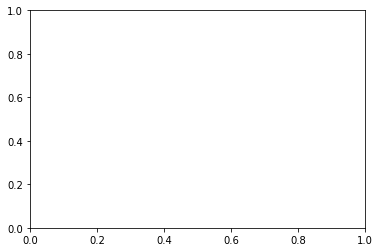

In [11]:
"""
# Plot average losses
avg_losses = []
avg_losses.append(D_A_avg_losses)
avg_losses.append(D_B_avg_losses)
avg_losses.append(G_A_avg_losses)
avg_losses.append(G_B_avg_losses)
avg_losses.append(cycle_A_avg_losses)
avg_losses.append(cycle_B_avg_losses)
utils.plot_loss(avg_losses, params.num_epochs, save=True, save_dir=save_dir)

# Make gif
utils.make_gif(params.dataset, params.num_epochs, save_dir=save_dir)
"""

# Save trained parameters of model
torch.save(G_A.state_dict(), model_dir + 'generator_A_param.pkl')
torch.save(G_B.state_dict(), model_dir + 'generator_B_param.pkl')
torch.save(D_A.state_dict(), model_dir + 'discriminator_A_param.pkl')
torch.save(D_B.state_dict(), model_dir + 'discriminator_B_param.pkl')